<a href="https://colab.research.google.com/github/wastb/KIAM-Week4/blob/Task2/notebooks/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Poblem Statement***

*The Finance team at Rossman Pharmaceuitcal wants to forecast sales in all their stores across several cities six weeks ahead of time.*

#### ***Data***
1. **Store Data** : *Contains Details about stores*
2. **Train Data** : *Training Data including Amount of Past sales*
3. **Test Data** : *Test data Used to forecast the Sales amount*

The above data can be found here [Rossmann Data](https://drive.google.com/file/d/1g7bh8mtpwa_VWKxfjMaDH8FngiV8ieXo/view?usp=drive_link)





In [1]:
!pip install tensorflow

In [2]:
## Import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from datetime import datetime
import os
import joblib

In [3]:
%cd /content/drive/MyDrive/Google Colab Folder/KIAM-Week4

/content/drive/MyDrive/Google Colab Folder/KIAM-Week4


In [4]:
%cd scripts

/content/drive/MyDrive/Google Colab Folder/KIAM-Week4/scripts


In [5]:
## Import custom modules
import preprocessing

#### ***Load Data***

In [6]:
## Use The preprocessing script to load the data from a google drive

df_store = preprocessing.load_data('/content/drive/MyDrive/Google Colab Folder/KIAM-Week4/data/store.csv')
df_test = preprocessing.load_data('/content/drive/MyDrive/Google Colab Folder/KIAM-Week4/data/test.csv')
df_train = preprocessing.load_data('/content/drive/MyDrive/Google Colab Folder/KIAM-Week4/data/train.csv')

In [7]:
## View Sample Data
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
## View Sample Data
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
## View Sample Data
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
## Merge the Store data with train and test data

df_test_merged = pd.merge(df_store, df_test, on='Store')
df_train_merged = pd.merge(df_store, df_train, on='Store')

#### ***Pre-Processing***

*It is important to process the data into a format where it can be fed to a machine learning model. This typically means converting all non-numeric columns to numeric, handling NaN values, and generating new features from already existing features.*

##### ***Preprocess Training Data***

In [11]:
## General Information
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   StoreType                  1017209 non-null  object 
 2   Assortment                 1017209 non-null  object 
 3   CompetitionDistance        1014567 non-null  float64
 4   CompetitionOpenSinceMonth  693861 non-null   float64
 5   CompetitionOpenSinceYear   693861 non-null   float64
 6   Promo2                     1017209 non-null  int64  
 7   Promo2SinceWeek            509178 non-null   float64
 8   Promo2SinceYear            509178 non-null   float64
 9   PromoInterval              509178 non-null   object 
 10  DayOfWeek                  1017209 non-null  int64  
 11  Date                       1017209 non-null  object 
 12  Sales                      1017209 non-null  int64  
 13  Customers   

***Observation*** : There are some features with missing values and inappropriate data types.

In [12]:
## Check for missing values
missing_value_columns = [columns for columns in df_train_merged.columns if df_train_merged[columns].isnull().sum() > 0]
print(missing_value_columns)


['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


In [13]:
## Handle Missing Values
# Assuming Where Competition Distance is null there is no competition
preprocessing.replace_missing_values(df_train_merged)

In [14]:
## Change data types
preprocessing.change_datatypes(df_train_merged)

In [15]:
## Drop Unwanted columns
df_train_merged.drop(['PromoInterval'], axis=1, inplace=True)

In [16]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  int64         
 5   CompetitionOpenSinceYear   1017209 non-null  int64         
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  int64         
 9   DayOfWeek                  1017209 non-null  int64         
 10  Date                       1017209 non-null  datetime64[ns]
 11  Sales                      1017209 no

##### ***Preprocess Test Data***

In [17]:
## General Information
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      41088 non-null  int64  
 1   StoreType                  41088 non-null  object 
 2   Assortment                 41088 non-null  object 
 3   CompetitionDistance        40992 non-null  float64
 4   CompetitionOpenSinceMonth  25872 non-null  float64
 5   CompetitionOpenSinceYear   25872 non-null  float64
 6   Promo2                     41088 non-null  int64  
 7   Promo2SinceWeek            23856 non-null  float64
 8   Promo2SinceYear            23856 non-null  float64
 9   PromoInterval              23856 non-null  object 
 10  Id                         41088 non-null  int64  
 11  DayOfWeek                  41088 non-null  int64  
 12  Date                       41088 non-null  object 
 13  Open                       41077 non-null  flo

***Observation*** : There are some features with missing values and inappropriate data types.

In [18]:
## Check for missing values
missing_value_columns = [columns for columns in df_test_merged.columns if df_test_merged[columns].isnull().sum() > 0]
print(missing_value_columns)


['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Open']


In [19]:
## Handle Missing Values
# Assuming Where Competition Distance is null there is no competition
preprocessing.replace_missing_values(df_test_merged)

In [20]:
## Change data types
preprocessing.change_datatypes(df_test_merged)

In [21]:
## Drop Unwanted columns
df_test_merged.drop(['Id'], axis=1, inplace=True)

In [22]:
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      41088 non-null  int64         
 1   StoreType                  41088 non-null  object        
 2   Assortment                 41088 non-null  object        
 3   CompetitionDistance        41088 non-null  float64       
 4   CompetitionOpenSinceMonth  41088 non-null  int64         
 5   CompetitionOpenSinceYear   41088 non-null  int64         
 6   Promo2                     41088 non-null  int64         
 7   Promo2SinceWeek            41088 non-null  float64       
 8   Promo2SinceYear            41088 non-null  int64         
 9   PromoInterval              41088 non-null  object        
 10  DayOfWeek                  41088 non-null  int64         
 11  Date                       41088 non-null  datetime64[ns]
 12  Open

#### ***Feature Engineering for Test Data***

In [23]:
## Generate Additional Features for test data

#From The date columns
df_test_merged['Year'] = df_test_merged['Date'].dt.year
df_test_merged['Month'] = df_test_merged['Date'].dt.month
df_test_merged['Day'] = df_test_merged['Date'].dt.day
df_test_merged['Quarter'] = df_test_merged['Date'].dt.quarter

df_test_merged['IsBeginningOfMonth'] = df_test_merged['Day'].apply(lambda x: 1 if x <= 7 else 0)
df_test_merged['IsMidMonth'] = df_test_merged['Day'].apply(lambda x: 1 if 8 <= x <= 21 else 0)
df_test_merged['IsEndOfMonth'] = df_test_merged['Day'].apply(lambda x: 1 if x > 21 else 0)

#From Day of Week
df_test_merged['IsWeekday'] = df_test_merged['DayOfWeek'].isin([1, 5]).astype(int)
df_test_merged['IsWeekend'] = df_test_merged['DayOfWeek'].isin([6, 7]).astype(int)

#From Sales and Customers
df_test_merged['SalesPerCustomer'] = 0
df_test_merged['LogSales'] = 0

df_test_merged['SalesLag7'] = 0
df_test_merged['SalesRollingMean'] = 0

In [24]:
## Encode categorical Variables
non_numeric_columns = df_test_merged.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    df_test_merged[col] = label_encoder.fit_transform(df_test_merged[col].astype(str))

In [25]:
## Scale the data
columns_to_be_scaled = ['CompetitionDistance', 'SalesPerCustomer', 'LogSales', 'SalesLag7', 'SalesRollingMean']

scaler = StandardScaler()
df_test_merged[columns_to_be_scaled] = scaler.fit_transform(df_test_merged[columns_to_be_scaled])

In [26]:
# remove
df_test_merged.drop(columns=['Date'], inplace=True)

In [27]:
#remove
df_test_merged.drop(columns=['PromoInterval'], inplace=True)

#### ***Feature Engineering for Train Data***

In [28]:
## Generate Additional Features

#From The date columns
df_train_merged['Year'] = df_train_merged['Date'].dt.year
df_train_merged['Month'] = df_train_merged['Date'].dt.month
df_train_merged['Day'] = df_train_merged['Date'].dt.day
df_train_merged['Quarter'] = df_train_merged['Date'].dt.quarter

df_train_merged['IsBeginningOfMonth'] = df_train_merged['Day'].apply(lambda x: 1 if x <= 7 else 0)
df_train_merged['IsMidMonth'] = df_train_merged['Day'].apply(lambda x: 1 if 8 <= x <= 21 else 0)
df_train_merged['IsEndOfMonth'] = df_train_merged['Day'].apply(lambda x: 1 if x > 21 else 0)

#From Day of Week
df_train_merged['IsWeekday'] = df_train_merged['DayOfWeek'].isin([1, 5]).astype(int)
df_train_merged['IsWeekend'] = df_train_merged['DayOfWeek'].isin([6, 7]).astype(int)

#From Sales and Customers
df_train_merged['SalesPerCustomer'] = (df_train_merged['Sales'] / df_train_merged['Customers']).fillna(0)
df_train_merged['LogSales'] = np.log1p(df_train_merged['Sales'])

df_train_merged['SalesLag7'] = df_train_merged['Sales'].shift(7).fillna(0)
df_train_merged['SalesRollingMean'] = df_train_merged['Sales'].rolling(window=7).mean().fillna(0)

In [29]:
df_train_merged.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,...,Quarter,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,IsWeekday,IsWeekend,SalesPerCustomer,LogSales,SalesLag7,SalesRollingMean
0,1,c,a,1270.0,9,2008,0,0.0,2025,5,...,3,0,0,1,1,0,9.482883,8.568646,0.0,0.0
1,1,c,a,1270.0,9,2008,0,0.0,2025,4,...,3,0,0,1,0,0,9.194139,8.521384,0.0,0.0
2,1,c,a,1270.0,9,2008,0,0.0,2025,3,...,3,0,0,1,0,0,9.143403,8.472823,0.0,0.0
3,1,c,a,1270.0,9,2008,0,0.0,2025,2,...,3,0,0,1,0,0,8.948214,8.519590,0.0,0.0
4,1,c,a,1270.0,9,2008,0,0.0,2025,1,...,3,0,0,1,1,0,9.970588,8.716536,0.0,0.0


In [30]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  int64         
 5   CompetitionOpenSinceYear   1017209 non-null  int64         
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  int64         
 9   DayOfWeek                  1017209 non-null  int64         
 10  Date                       1017209 non-null  datetime64[ns]
 11  Sales                      1017209 no

In [31]:
## Encode categorical Variables
non_numeric_columns = df_train_merged.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    df_train_merged[col] = label_encoder.fit_transform(df_train_merged[col].astype(str))

df_train_merged.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,...,Quarter,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,IsWeekday,IsWeekend,SalesPerCustomer,LogSales,SalesLag7,SalesRollingMean
0,1,2,0,1270.0,9,2008,0,0.0,2025,5,...,3,0,0,1,1,0,9.482883,8.568646,0.0,0.0
1,1,2,0,1270.0,9,2008,0,0.0,2025,4,...,3,0,0,1,0,0,9.194139,8.521384,0.0,0.0
2,1,2,0,1270.0,9,2008,0,0.0,2025,3,...,3,0,0,1,0,0,9.143403,8.472823,0.0,0.0
3,1,2,0,1270.0,9,2008,0,0.0,2025,2,...,3,0,0,1,0,0,8.948214,8.519590,0.0,0.0
4,1,2,0,1270.0,9,2008,0,0.0,2025,1,...,3,0,0,1,1,0,9.970588,8.716536,0.0,0.0


In [32]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  int64         
 2   Assortment                 1017209 non-null  int64         
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  int64         
 5   CompetitionOpenSinceYear   1017209 non-null  int64         
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  int64         
 9   DayOfWeek                  1017209 non-null  int64         
 10  Date                       1017209 non-null  datetime64[ns]
 11  Sales                      1017209 no

In [33]:
## Scale the data
columns_to_be_scaled = ['CompetitionDistance', 'SalesPerCustomer', 'LogSales', 'SalesLag7', 'SalesRollingMean']

scaler = StandardScaler()
df_train_merged[columns_to_be_scaled] = scaler.fit_transform(df_train_merged[columns_to_be_scaled])


In [34]:
# Define the target features
X = df_train_merged.drop(columns=['Sales', 'Date','Customers'])
y = df_train_merged['Sales']

In [35]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### ***Building Models With Sklearn Pipeline***

##### ***Random Forest Model***

In [36]:
# Define RandomForest model within a pipeline
pipeline_random_forest = Pipeline([('model', RandomForestRegressor(n_estimators=100, random_state=42))])
pipeline_random_forest.fit(X_train, y_train)


Pipeline(steps=[('model', RandomForestRegressor(random_state=42))])

In [37]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

In [38]:
## Evaluate the model
y_pred = pipeline_random_forest.predict(X_test)

# Evaluate on training set
mse_random_forest, mae_random_forest, r2_random_forest = evaluate_model(y_test, y_pred)
print(f"Evaluation Results: MSE: {mse_random_forest}, MAE: {mae_random_forest}, R2: {r2_random_forest}")

Evaluation Results: MSE: 1.5890624408922294, MAE: 0.022539937672658248, R2: 0.9999998924423508


###### ***Feature Importance and Confidence Interval***

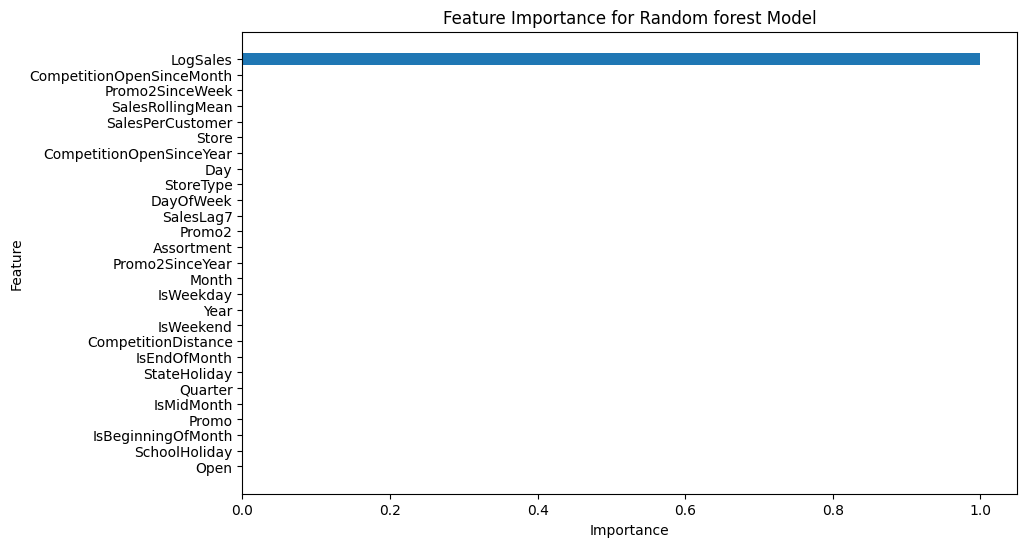

In [39]:
# Get the model
rf_model = pipeline_random_forest.named_steps['model']

#Feature importance
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

## Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random forest Model')
plt.gca().invert_yaxis()
plt.show()


In [40]:
## Estimate the Confidence interval
# Get predictions from each tree in the Random Forest
all_tree_predictions = np.array([tree.predict(X_test.values) for tree in rf_model.estimators_])

# Calculate mean and standard deviation of predictions
mean_predictions = np.mean(all_tree_predictions, axis=0)
std_predictions = np.std(all_tree_predictions, axis=0)

# Confidence interval (95%)
#For 95% confidence level
z = 1.96
lower_bound = mean_predictions - z * std_predictions
upper_bound = mean_predictions + z * std_predictions

# Combine results in a DataFrame
predictions_df = pd.DataFrame({
    'Mean Prediction': mean_predictions,
    'Lower Bound (95%)': lower_bound,
    'Upper Bound (95%)': upper_bound
})

print(predictions_df.head())

   Mean Prediction  Lower Bound (95%)  Upper Bound (95%)
0           8336.0             8336.0             8336.0
1           2193.0             2193.0             2193.0
2           5375.0             5375.0             5375.0
3           3911.0             3911.0             3911.0
4           5604.0             5604.0             5604.0


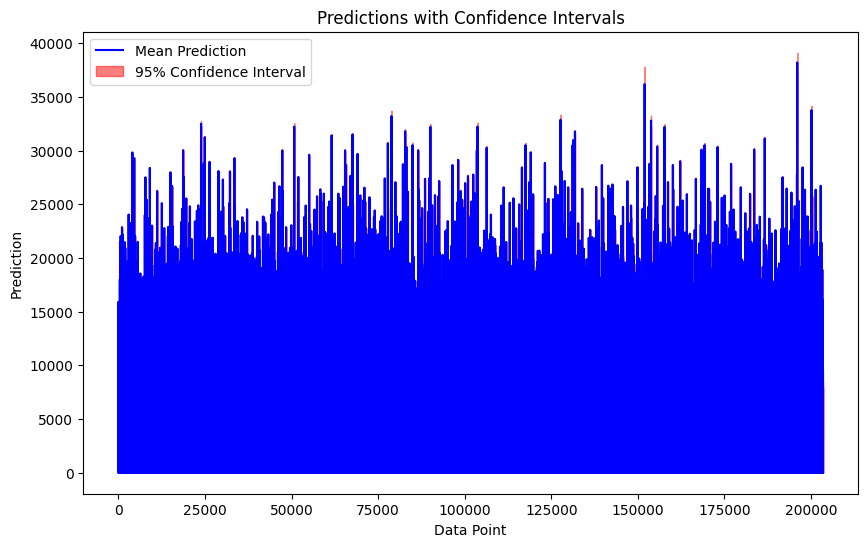

In [41]:
## Visualize the confidence interval

plt.figure(figsize=(10, 6))
plt.plot(mean_predictions, label='Mean Prediction', color='blue')
plt.fill_between(range(len(mean_predictions)), lower_bound, upper_bound, color='red', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Data Point')
plt.ylabel('Prediction')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.show()

In [42]:
## Predict sales for the next 6 months
sales_pred = pipeline_random_forest.predict(df_test_merged)
sales_pred_rf_df = pd.DataFrame(sales_pred)
sales_pred_rf_df.head()

,0
0,1435.15
1,1435.15
2,1435.15
3,1435.15
4,1435.14


In [43]:
## Save the model

model_dir = '/content/drive/MyDrive/Google Colab Folder'

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"{model_dir}/sales_model_{timestamp}.pkl"
joblib.dump(pipeline_random_forest, model_filename)

print(f"Model saved as {model_filename}")

Model saved as /content/drive/MyDrive/Google Colab Folder/sales_model_2025-01-14-10-11-40.pkl


##### ***XGboost Model***

In [ ]:
# Define the pipeline
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)


In [45]:
## Evaluate the model
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate on training set
mse_xgb, mae_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"Evaluation Results: MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")

Evaluation Results: MSE: 11046.59765625, MAE: 20.509239196777344, R2: 0.9992523193359375


#### ***Feature Importance and Confidence interval for XGBoost Model***

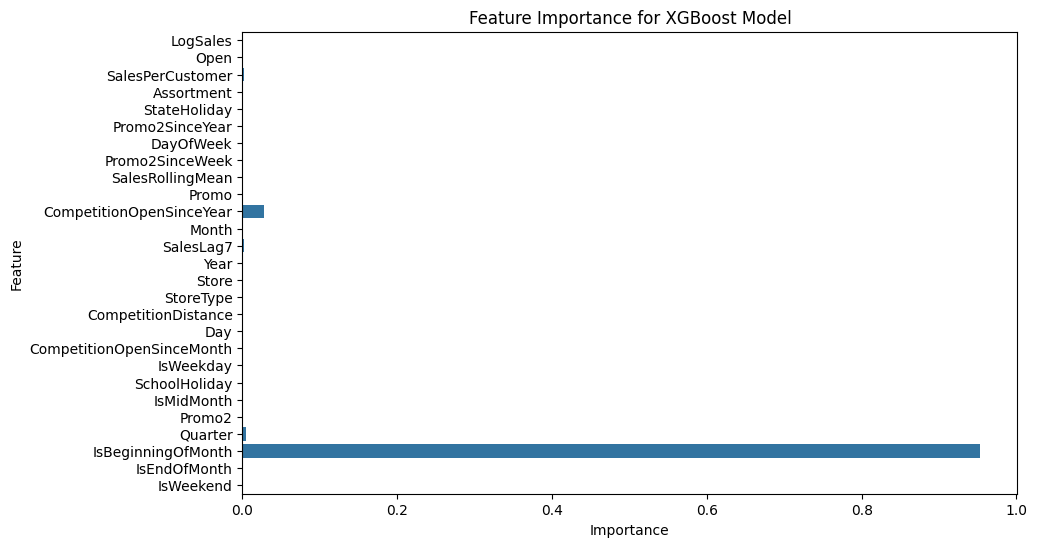

In [46]:
## Feature importance

# Get feature importance using 'weight' or 'gain'
importance = model_xgb.feature_importances_

# construct a dataframe
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=xgb_feature_importance_df.Feature, data=xgb_feature_importance_df)
plt.title("Feature Importance for XGBoost Model")
plt.xlabel("Importance")
plt.show()

In [47]:
## Calculate the confidence interval

# Number of bootstrap iterations
n_iterations = 100
n_size = len(X_test)

# Store predictions from each bootstrap iteration
bootstrap_predictions = []

for i in range(n_iterations):
    # Bootstrap sample (sampling with replacement)
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=n_size, random_state=i)

    # Get predictions for this bootstrap sample
    y_pred = model_xgb.predict(X_resampled)

    # Store the predictions
    bootstrap_predictions.append(y_pred)

# Convert list of predictions to a numpy array for analysis
bootstrap_predictions = np.array(bootstrap_predictions)

# Calculate mean and standard deviation of predictions across all bootstraps
mean_predictions = np.mean(bootstrap_predictions, axis=0)
std_predictions = np.std(bootstrap_predictions, axis=0)

# Confidence interval (95%) - For 95% confidence level
z = 1.96
lower_bound = mean_predictions - z * std_predictions
upper_bound = mean_predictions + z * std_predictions

# Combine results in a DataFrame
predictions_df = pd.DataFrame({
    'Mean Prediction': mean_predictions,
    'Lower Bound (95%)': lower_bound,
    'Upper Bound (95%)': upper_bound
})

# Show the predictions and their confidence intervals
print(predictions_df)

        Mean Prediction  Lower Bound (95%)  Upper Bound (95%)
0           5824.266113       -1406.457520       13054.990234
1           6198.631348       -1904.277832       14301.541016
2           5905.703125       -2031.675293       13843.082031
3           5249.662598       -2147.221680       12646.546875
4           5969.283203       -2018.081543       13956.648438
...                 ...                ...                ...
203437      5231.588867       -1993.960449       12457.138672
203438      5689.728516       -1713.329102       13092.786133
203439      5344.787109       -2045.927246       12735.501953
203440      5809.065430       -1851.356934       13469.488281
203441      5458.956055       -2384.698242       13302.610352

[203442 rows x 3 columns]


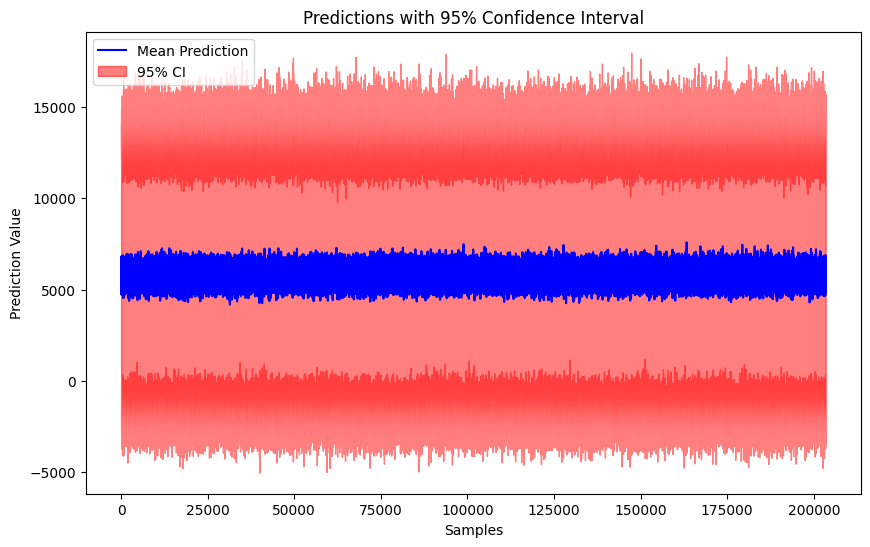

In [48]:
# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(mean_predictions, label='Mean Prediction', color='blue')
plt.fill_between(range(len(mean_predictions)), lower_bound, upper_bound, color='red', alpha=0.5, label='95% CI')
plt.title('Predictions with 95% Confidence Interval')
plt.xlabel('Samples')
plt.ylabel('Prediction Value')
plt.legend()
plt.show()

In [49]:
## Predict sales for the next 6 months
sales_pred = model_xgb.predict(df_test_merged)
sales_pred_xgb_df = pd.DataFrame(sales_pred)
sales_pred_xgb_df.head()

,0
0,1499.220093
1,1499.220093
2,1499.220093
3,1499.272583
4,1192.773682


In [50]:
## Save the model

model_dir = '/content/drive/MyDrive/Google Colab Folder'

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"{model_dir}/sales_model_xgb_{timestamp}.pkl"
joblib.dump(model_xgb, model_filename)

print(f"Model saved as {model_filename}")

Model saved as /content/drive/MyDrive/Google Colab Folder/sales_model_xgb_2025-01-14-10-13-02.pkl


### ***Model Building with LSTM***

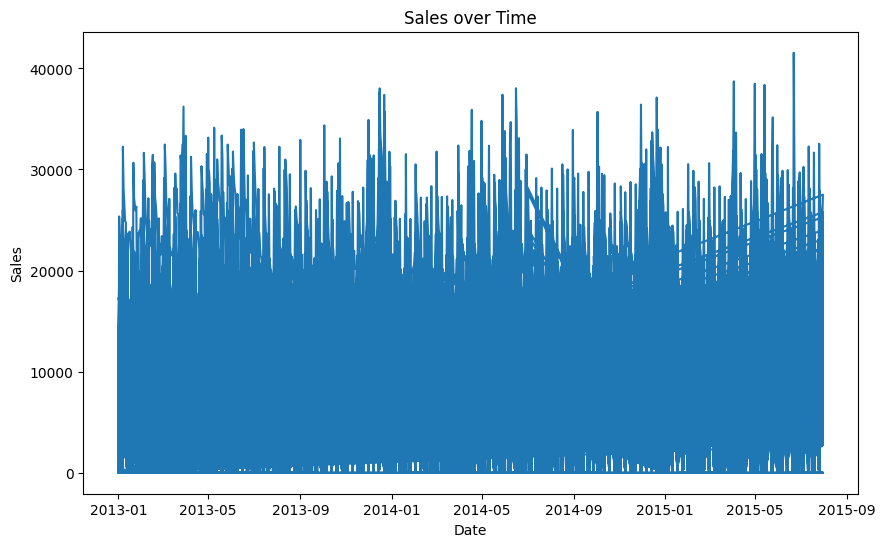

In [51]:
## Isolate the train data into time series data
df_time_series = df_train_merged[['Date', 'Sales']]

# Set Date as the index
df_time_series.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df_time_series['Sales'])
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [52]:
# Perform the Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    print('ADFuller Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

# Check stationarity of the sales data
check_stationarity(df_time_series['Sales'].iloc[:10000])

ADFuller Statistic: -4.562879227487369
p-value: 0.00015112376064850926
Data is stationary


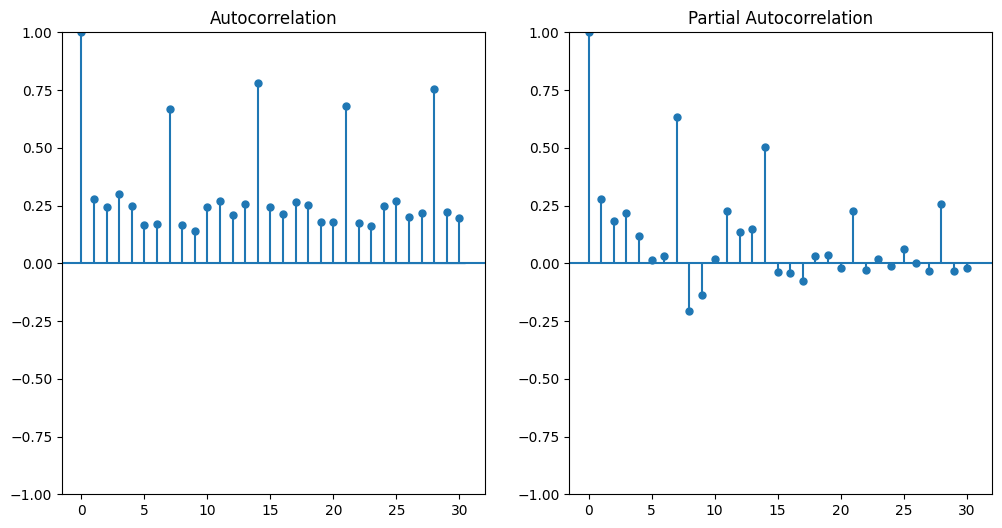

In [53]:
# Plot autocorrelation and partial autocorrelation
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_time_series['Sales'], lags=30, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_time_series['Sales'], lags=30, ax=plt.gca())
plt.show()

In [54]:
# Scaling the sales data
sales = df_time_series['Sales'].values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(sales.reshape(-1, 1))

## Transform into supervised learning data
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Set the window size for the sliding window (e.g., 30 time steps)
window_size = 60
X_lstm, y_lstm = create_supervised_data(scaled_sales, window_size)

# Split data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [55]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))  # Second layer of LSTM
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1075s 84ms/step - loss: 0.0264 - val_loss: 0.0105
Epoch 2/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1077s 85ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 3/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1124s 86ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 4/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1054s 83ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 5/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1045s 82ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 6/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1122s 84ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 7/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1058s 83ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 8/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1104s 83ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1062s 84ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 1105s 84ms/step - loss: 0.0030 - val_loss: 0.0023


In [57]:
## Evaluate the model
y_pred_lstm = model.predict(X_test_lstm)

# Evaluate on training set
mse_lstm, mae_lstm, r2_lstm = evaluate_model(y_test_lstm, y_pred_lstm)
print(f"Evaluation Results: MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")

6358/6358 ━━━━━━━━━━━━━━━━━━━━ 119s 19ms/step
Evaluation Results: MSE: 0.002293709214783168, MAE: 0.028671138970165013, R2: 0.9331560702987883


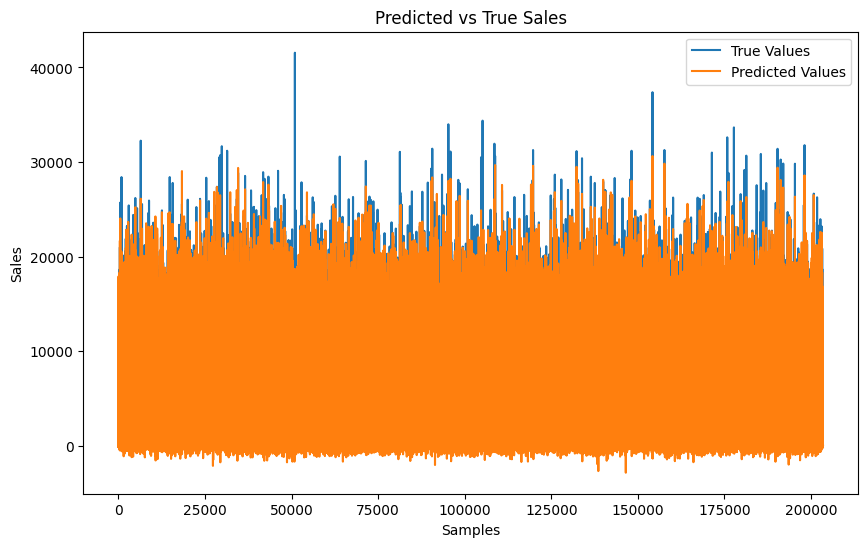

In [59]:
# Inverse transform the predictions and true values
y_pred_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Plot the predicted vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='True Values')
plt.plot(y_pred_inv, label='Predicted Values')
plt.title('Predicted vs True Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [60]:
## Save the model

model_dir = '/content/drive/MyDrive/Google Colab Folder'

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"{model_dir}/sales_model_lstm_{timestamp}.pkl"
joblib.dump(model, model_filename)

print(f"Model saved as {model_filename}")

Model saved as /content/drive/MyDrive/Google Colab Folder/sales_model_lstm_2025-01-14-13-29-42.pkl
